In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [14]:
#load stored values
%store -r x_train x_val x_test y_train y_val y_test

In [15]:
def lognormalise(y):
    yl = np.log(y+1)
    mu = yl.mean()
    std = yl.std()
    
    y_ret = (yl - mu) / std
    
    return y_ret, mu, std

def unlognormalise(y, mu, std):
    return np.exp((y * std)+mu) - 1

y_train_ln, y_mu, y_std = lognormalise(y_train)

In [3]:
class GPR:
    
    def __init__(self,l2,s2,n):
        self.l2 = l2
        self.s2 = s2
        self.n = n
        
        
    def rbf_kernel(self,a,b):
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
        return np.exp(-.5 * (1/self.l2) * sqdist) * self.s2 
    
    
    def regress(self,x_train,x_test,y_train, var=False):
        N = x_train.shape[0]
        K = self.rbf_kernel(x_train, x_train)
        L = np.linalg.cholesky(K + self.n*np.eye(N))
        L_st = np.linalg.solve(L, self.rbf_kernel(x_train, x_test))
        mu = np.dot(L_st.T, np.linalg.solve(L, y_train))
        mu_norm = unlognormalise(mu, y_mu, y_std)
        self.mu = mu_norm
        if var:
            K_stst = self.rbf_kernel(x_test, x_test)
            var2 = np.diag(K_stst) - np.sum(L_st**2, axis=0)
            var = np.sqrt(var2)
            #needs scaling 
            self.var = var
    
    def regress_self(self,x_train,y_train):
        N = x_train.shape[0]
        K = self.rbf_kernel(x_train, x_train)
        L = np.linalg.cholesky(K + self.n*np.eye(N))
        L_st = np.linalg.solve(L, K)
        mu = np.dot(L_st.T, np.linalg.solve(self.L, y_train))
        mu_norm = unlognormalise(mu, y_mu, y_std)
        self.mu_train = mu_norm

        
    def get_rmse(self,y_act):
        mse = np.mean(np.square(self.mu - y_act))
        rmse = np.sqrt(mse)
        self.rmse = rmse
        return rmse     
    
    def return_metrics(self,y_act):
        mae = np.mean(abs(self.mu - y_act))
        mse = np.mean(np.square(self.mu - y_act))
        rmse = np.sqrt(mse)
        sey = sum(np.square(y_act-y_act.mean()))
        ser = sum(np.square(y_act-self.mu))
        r2 = 1 - (ser/sey)
        
        self.mse = mse
        self.rmse = rmse
        self.mae = mae
        self.r2 = r2
        
        return mse, rmse, mae, r2
    

    def tune_hp(self, l2_range, s2_range, n_range, num_its, x_train, x_val, y_train, y_val):
        
        rmses = []
        
        # convert ranges to lists of hps to try
        l2 = (1 - np.sqrt(1 - np.random.rand(num_its))) * (l2_range[1]-l2_range[0]) + l2_range[0]
        s2 = (1 - np.sqrt(1 - np.random.rand(num_its))) * (s2_range[1]-s2_range[0]) + s2_range[0]
        n = (1 - np.sqrt(1 - np.random.rand(num_its))) * (n_range[1]-n_range[0]) + n_range[0]
        
        # iterate
        print(f"Running iteration 1 of {num_its}...")
        start_time = time.time()
        
        for i in range(num_its):
            
            #print status
            if i:
                run_time = (time.time() - start_time)/60
                time_left = (run_time / i) * (num_its - i)
                print(f"Running iteration {i+1} of {num_its}... time elapsed = {run_time:.01f}m, time left = {time_left:.01f}m")
                
            # reinitialise gp attributes
            self.l2 = l2[i]
            self.s2 = s2[i]
            self.n = n[i]
        
            # run regress
            self.regress(x_train, x_val, y_train)
         
            # return rmse and store in a vector array
            r = self.get_rmse(y_val)
            rmses.append(r)
        
            
        return n,s2,l2,rmses

    
    

In [31]:
g = GPR(1,1,0.5)

In [32]:
gp_tuning = g.tune_hp([0,2],[0,2],[0,1],50, x_train, x_val, y_train_ln, y_val)

Running iteration 1 of 50...
Running iteration 2 of 50... time elapsed = 4.2 mins, time left = 207.9
Running iteration 3 of 50... time elapsed = 8.8 mins, time left = 210.3
Running iteration 4 of 50... time elapsed = 13.3 mins, time left = 209.0
Running iteration 5 of 50... time elapsed = 17.9 mins, time left = 205.4
Running iteration 6 of 50... time elapsed = 22.4 mins, time left = 201.3
Running iteration 7 of 50... time elapsed = 26.9 mins, time left = 197.6
Running iteration 8 of 50... time elapsed = 31.4 mins, time left = 192.8
Running iteration 9 of 50... time elapsed = 35.8 mins, time left = 187.7
Running iteration 10 of 50... time elapsed = 40.3 mins, time left = 183.5
Running iteration 11 of 50... time elapsed = 44.7 mins, time left = 178.8
Running iteration 12 of 50... time elapsed = 49.3 mins, time left = 174.9
Running iteration 13 of 50... time elapsed = 53.7 mins, time left = 170.2
Running iteration 14 of 50... time elapsed = 87.7 mins, time left = 249.5
Running iteration 1

In [6]:
%store -r gp_tuning

In [7]:
ix = gp_tuning[3].index(min(gp_tuning[3]))
optimal_params = [i[ix] for i in gp_tuning]

In [46]:
n,s2,l2,rmses  = gp_tuning
r = np.array(rmses)

In [42]:
optimal_params

[0.11471682778940862,
 0.8438299281056307,
 1.7951699732088338,
 2.0974038375772555]

In [75]:
gopt = GPR(optimal_params[2],optimal_params[1],optimal_params[0])

In [81]:
%%time
gopt.regress(x_train,x_test,y_train_ln, var = True)

Wall time: 4min 50s


In [82]:
gopt.get_rmse(y_test)

1.9479539174701332

In [94]:
#gauss_maes = abs(gopt.mu - y_test)
%store -r gauss_maes

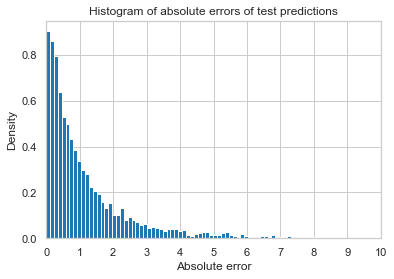

In [174]:
sns.set_context('notebook')
plt.hist(gauss_maes,density=True,bins=200)
plt.xlim([0,10])
plt.xticks(list(range(11)))
plt.title('Histogram of absolute errors of test predictions')
plt.xlabel('Absolute error')
plt.ylabel('Density')
plt.savefig('figures\\aehist.png')
plt.show()

# Hyperparameter tuning visualisations

In [63]:
import seaborn as sns
sns.set_context('notebook')
sns.set_style('whitegrid')

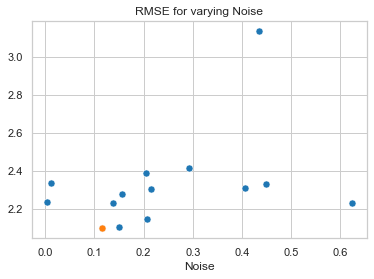

In [91]:
#sns.scatterplot(x=n,y=r,s=50)
sns.scatterplot(x=n[l2>0.9],y=r[l2>0.9],s=50)
sns.scatterplot(x=[optimal_params[0]],y=[optimal_params[3]],marker='o',s=50)
plt.title('RMSE for varying Noise')
plt.xlabel('Noise')
plt.savefig('figures\\gphp3.png')
plt.show()

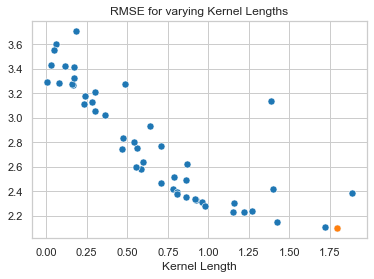

In [84]:
sns.scatterplot(x=l2,y=r,s=50)
sns.scatterplot(x=[optimal_params[2]],y=[optimal_params[3]],s=50)
plt.title('RMSE for varying Kernel Lengths')
plt.xlabel('Kernel Length')
plt.savefig('figures\\gphp1.png')
plt.show()

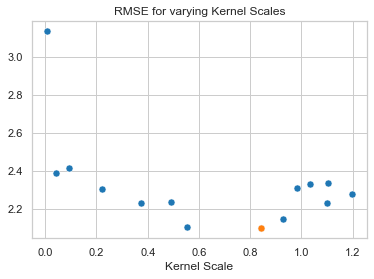

In [88]:
sns.scatterplot(x=s2[l2>0.9],y=r[l2>0.9],s=50)
#sns.scatterplot(x=s2,y=r,s=50)
sns.scatterplot(x=[optimal_params[1]],y=[optimal_params[3]],s=50)
plt.title('RMSE for varying Kernel Scales')
plt.xlabel('Kernel Scale')
plt.savefig('figures\\gphp2.png')
plt.show()

In [197]:
#import dill
#dill.dump_session('Gaussian_Process.db')

# Toy Problem

In [37]:
%store -r x_toy_train y_toy_train x_toy_test y_toy_test

In [38]:
gp_toy = GPR(optimal_params[2],optimal_params[1],0.00001)
y_train_ln, y_mu, y_std = lognormalise(y_toy_train)
gp_toy.regress(x_toy_train,x_toy_test,y_train_ln, var = False)
y_pred_toy = gp_toy.mu

In [39]:
ae_toy = abs(y_pred_toy - y_toy_test)
mae_toy = ae_toy.mean()
mse_toy = (np.square(ae_toy).sum())/y_pred_toy.shape[0]
rmse_toy = np.sqrt(mse_toy)
print(f"RMSE for the toy problem = {rmse_toy:.04f}")

RMSE for the toy problem = 0.0015


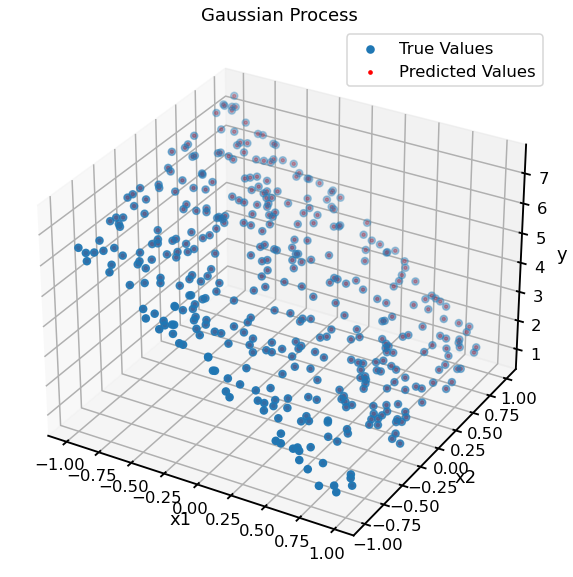

In [40]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_context("talk")
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x_toy_test[:,0], x_toy_test[:,1], y_toy_test, s=50,label='True Values')
ax.scatter(x_toy_test[:,0], x_toy_test[:,1], y_pred_toy, color='r',s=10,label='Predicted Values')
plt.legend()
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
ax.set_title("Gaussian Process")
plt.savefig("figures\\gptoy.png")
plt.show()